# @robotodio

---

## Libraries

In [21]:
# Python libraries
# ------------------------------------------------------------------------------
# Enviroment
import os
from sinfo import sinfo

# Reading files with different formats
import json

# Data wrangling
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords

# Data Visualitation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Twitter API
import tweepy

# Hate speech detection
from detoxify import Detoxify

sinfo()

-----
detoxify    NA
matplotlib  3.3.2
nltk        3.5
numpy       1.19.2
pandas      1.2.0
seaborn     0.11.1
sinfo       0.3.1
tweepy      3.10.0
wordcloud   1.8.1
-----
IPython             7.19.0
jupyter_client      6.1.7
jupyter_core        4.7.0
jupyterlab          2.2.6
notebook            6.1.6
-----
Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
4 logical CPU cores, Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
-----
Session information updated at 2021-03-23 18:25


## 1. Download data from twitter

The tweepy API class provides access to the entire Twitter RESTful API methods. Each method can accept various parameters and return responses to the different requests.

### 1.1. API set up

In order for you to get the Twitter feed working you need four keys: 

- Consumer Key
- Consumer Secret
- Access Token
- Access Token Secret

If you have a developer Twitter account you can generate your own tokens and log in with them. In case you don't have a developer account, please contact me and I will provide mine.

In [2]:
# API Twitter credentials
# ------------------------------------------------------------------------------
# Open .json file containing credentials/tokens as a dictionary
with open("../twitter_api_keys.json") as file:
    api_credentials = json.load(file)
    
# Assign each value of the dictionary to a new variable
consumer_key = api_credentials['consumer_key']
consumer_secret = api_credentials['consumer_secret']
access_token = api_credentials['access_token']
access_token_secret = api_credentials['access_token_secret']

In [3]:
# API set up
# ------------------------------------------------------------------------------
# Create a handler instance with key and secret consumer, and pass the tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
    
# Construct the API instance
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Check credentials
if(api.verify_credentials):
    print('-'*30)
    print("Logged In Successfully.")
    print('-'*30)
else:
    print("Error -- Could not log in with your credentials.")

------------------------------
Logged In Successfully.
------------------------------


### 1.2. Extract tweets and associated metadata

Once the `tweepy.API` class has been instantiated we can call its methods to scrap desired information in Twitter.

Pagination is used a lot in Twitter API development. Iterating through timelines, user lists, direct messages, etc. In order to perform pagination, we must supply a page/cursor parameter with each of our requests. The problem here is this requires a lot of boiler plate code just to manage the pagination loop. To help make pagination easier and require less code, Tweepy has the Cursor object.

In first place, we are going to define a function that returns an iterator of tweets. We will call this fuction each time we want to download tweets from an user account.

In [4]:
# Tweets list iterator
# ------------------------------------------------------------------------------
def tweets_iterator(target, n_items):
    '''
    Returns an iterator of tweets.

        Parameters:
            target (str): The user name of the Twitter account.
            n_items (int): Number of tweets downloaded.

        Returns:
            tweets (ItemIterator): an iterator of tweets.
    '''
    # Instantiate the iterator
    tweets = tweepy.Cursor(
        api.user_timeline,
        screen_name=target,
        include_rts=False,
        exclude_replies=False,
        tweet_mode='extended').items(n_items)
    
    # Returns iterator
    return tweets

In the next cell we are going to download $n$ tweets from a Twitter account, and examinate the content of the first tweet with all the metadata associated.

In [39]:
# Introduce the target Twitter account and number of items to download

# target = 'DFD_74'

target = 'Martasc94'
n_items = 300

# Tweets list (iterator)
tweets = tweets_iterator(target, n_items=1)

# Print the first tweet with .json format
print(json.dumps(next(tweets)._json, indent=4))

{
    "created_at": "Sat Feb 20 12:01:58 +0000 2021",
    "id": 1363096556979765249,
    "id_str": "1363096556979765249",
    "full_text": "Falta conciencia sobre la diferencia abismal entre o\u00edr y escuchar.",
    "truncated": false,
    "display_text_range": [
        0,
        66
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": []
    },
    "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 418207041,
        "id_str": "418207041",
        "name": "Marta",
        "screen_name": "Martasc94",
        "location": "Madrid ",
        "description": "Ser sensible es ser valiente.  Ig: martascr_",
        "url": null,
        "entities": {
            "description

As we can see in the previous output cell, each tweet contains a lot of metadata. All this information comes in .json format, and we can access to it with Tweepy methods, or with dictionary methods.

In the next cell we are going to extract some metadata from each tweet, and export to a Pandas DataFrame format.

In [40]:
# Tweet extractor
# ------------------------------------------------------------------------------
# Tweets list (iterator)
tweets = tweets_iterator(target, n_items)

# Read through the iterator, and export the info to a Pandas DataFrame
all_columns = [np.array([
    tweet.full_text,
    tweet.user.screen_name,
    tweet.id,
    tweet.user.followers_count,
    tweet.source,
    tweet.created_at,
    tweet.lang,
    len(tweet.full_text),
    tweet.favorite_count,
    tweet.retweet_count,
    re.findall(r"#(\w+)", tweet.full_text)
]) for tweet in tweets]

# Export the list of tweets to a dataframe
df = pd.DataFrame(
    data=all_columns,
    columns=['tweet', 'account', 'id', 'followers', 'source', 'date', 'language',
             'length', 'likes', 'RTs', 'hashtags'])

df.head()

<ipython-input-40-6436858e4064>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_columns = [np.array([


,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags
0,Falta conciencia sobre la diferencia abismal e...,Martasc94,1363096556979765249,780,Twitter for iPhone,2021-02-20 12:01:58,es,66,4,1,[]
1,https://t.co/lbcgdlsx8n https://t.co/2YEeS0zuLO,Martasc94,1361669050875731970,780,Twitter for iPhone,2021-02-16 13:29:34,und,47,12,7,[]
2,"‘Odio los mapas, me gusta perderme.\nMe encont...",Martasc94,1352906668783316992,780,Twitter for iPhone,2021-01-23 09:11:00,es,80,3,1,[]
3,"‘Madrid invierno, un frio de la hostia, abroch...",Martasc94,1347680372994301952,780,Twitter for iPhone,2021-01-08 23:03:34,es,59,1,0,[]
4,Los días de niebla 🖤,Martasc94,1341734677342777346,780,Twitter for iPhone,2020-12-23 13:17:29,es,20,0,0,[]


In addition, we are going to create another dataframe with the main data of the target account:

In [41]:
# Account data extractor
# ------------------------------------------------------------------------------
# Tweets list (iterator)
tweets = tweets_iterator(target, n_items=1)

# Read through the iterator, and export the info to a Pandas DataFrame
data_account = [np.array([
    tweet.user.screen_name,
    tweet.user.name,
    tweet.user.description,
    tweet.user.created_at,
    tweet.user.friends_count,
    tweet.user.followers_count,
    tweet.user.statuses_count
]) for tweet in tweets]

# Export the list of features to a dataframe
df_account = pd.DataFrame(
    data=data_account,
    columns=['account', 'account_name', 'bio_description', 'creation_date', 'friends',
             'followers', 'tweets']
)

df_account = pd.melt(df_account)
df_account

,variable,value
0,account,Martasc94
1,account_name,Marta
2,bio_description,Ser sensible es ser valiente. Ig: martascr_
3,creation_date,2011-11-21 22:00:35
4,friends,641
5,followers,780
6,tweets,19324


### 1.3. Clean and translation

Once we have a dataset with all the tweets of an user, we need to prepare and clean them to serve as input to the model. For each tweet we are going to eliminate special string characters, and we will translate them into English in case they are not.

The traduction is needed for two mains reasons:

- Make a more robust and extensible app
- Detoxify model provides more information when the input is in english language

**Cleaning:**

In [42]:
# Data cleaning
# ------------------------------------------------------------------------------
# Characters to remove
spec_chars = ['\n', '\t', '\r']

# Replace defined characters with a whitespace
for char in spec_chars:
    df['tweet'] = df['tweet'].str.strip().replace(char, ' ')

Because we replaced the special characters with a whitespace, we might end up with double whitespaces in some values. Let’s remove them by splitting each tweet using whitespaces and re-joining the words again using join.

In [43]:
# Split and re-join each tweet
df['tweet'] = df['tweet'].str.split().str.join(" ")

In [44]:
df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags
0,Falta conciencia sobre la diferencia abismal e...,Martasc94,1363096556979765249,780,Twitter for iPhone,2021-02-20 12:01:58,es,66,4,1,[]
1,https://t.co/lbcgdlsx8n https://t.co/2YEeS0zuLO,Martasc94,1361669050875731970,780,Twitter for iPhone,2021-02-16 13:29:34,und,47,12,7,[]
2,"‘Odio los mapas, me gusta perderme. Me encontr...",Martasc94,1352906668783316992,780,Twitter for iPhone,2021-01-23 09:11:00,es,80,3,1,[]
3,"‘Madrid invierno, un frio de la hostia, abroch...",Martasc94,1347680372994301952,780,Twitter for iPhone,2021-01-08 23:03:34,es,59,1,0,[]
4,Los días de niebla 🖤,Martasc94,1341734677342777346,780,Twitter for iPhone,2020-12-23 13:17:29,es,20,0,0,[]


## 2. Hate speech level prediction

`Detoxify` library has three pre-trained models:

- original: toxic, severe_toxic, obscene, threat, insult, identity_hate.
- unbiased: toxicity, severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit.
- multilingual: toxicity

While *original* and *unbiased* models generate different scorings like: toxicity, obscene, threat, insult...etc, *multilingual* model only produces a toxicity scoring. On the other hand, *multilingual* model is the only one that can bring a toxicity score in a language different from english.

In this notebook we are going to use *multilingual* model.

In [45]:
# Hate speech level prediction
# ------------------------------------------------------------------------------
# Returns a dictionary with toxicity values of each tweet. The key of the
# dictionary is called toxicity.
results = Detoxify('multilingual').predict(list(df['tweet']))
results

{'toxicity': [0.012530445121228695,
  0.0004945207037962973,
  0.19198712706565857,
  0.16682349145412445,
  0.07480422407388687,
  0.046483006328344345,
  0.04843035712838173,
  0.9914929270744324,
  0.6283828616142273,
  0.038901105523109436,
  0.00477761123329401,
  0.10981792211532593,
  0.08323647081851959,
  0.0005192167591303587,
  0.3688569962978363,
  0.02348695695400238,
  0.10714889317750931,
  0.00044030521530658007,
  0.07614636421203613,
  0.0005819218931719661,
  0.5824424624443054,
  0.05037039518356323,
  0.8093501925468445,
  0.00133251934312284,
  0.6174165606498718,
  0.0027046455070376396,
  0.053374722599983215,
  0.10419865697622299,
  0.08881975710391998,
  0.027559565380215645,
  0.9689114093780518,
  0.012544382363557816,
  0.12267369776964188,
  0.018159668892621994,
  0.2092398852109909,
  0.06118137016892433,
  0.00043416506377980113,
  0.1813536286354065,
  0.004024956841021776,
  0.6111927032470703,
  0.029683541506528854,
  0.0007363597396761179,
  0.052

In [46]:
# Add the new info to the previous DataFrame
df['toxicity'] = results['toxicity']

df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity
0,Falta conciencia sobre la diferencia abismal e...,Martasc94,1363096556979765249,780,Twitter for iPhone,2021-02-20 12:01:58,es,66,4,1,[],0.012530
1,https://t.co/lbcgdlsx8n https://t.co/2YEeS0zuLO,Martasc94,1361669050875731970,780,Twitter for iPhone,2021-02-16 13:29:34,und,47,12,7,[],0.000495
2,"‘Odio los mapas, me gusta perderme. Me encontr...",Martasc94,1352906668783316992,780,Twitter for iPhone,2021-01-23 09:11:00,es,80,3,1,[],0.191987
3,"‘Madrid invierno, un frio de la hostia, abroch...",Martasc94,1347680372994301952,780,Twitter for iPhone,2021-01-08 23:03:34,es,59,1,0,[],0.166823
4,Los días de niebla 🖤,Martasc94,1341734677342777346,780,Twitter for iPhone,2020-12-23 13:17:29,es,20,0,0,[],0.074804


Once we have a score for each tweet, we can define a toxicity threshold and aggregate these puntuactions by calculating the average. According to Detoxify documentation, a tweet can be toxic when the score is around 0.5.

> *Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).
URL: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data*

In [47]:
# Define a class for each tweet
df['class'] = df['toxicity'].apply(lambda toxicity: 'toxic' if toxicity >= 0.5 else 'non-toxic')
df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity,class
0,Falta conciencia sobre la diferencia abismal e...,Martasc94,1363096556979765249,780,Twitter for iPhone,2021-02-20 12:01:58,es,66,4,1,[],0.012530,non-toxic
1,https://t.co/lbcgdlsx8n https://t.co/2YEeS0zuLO,Martasc94,1361669050875731970,780,Twitter for iPhone,2021-02-16 13:29:34,und,47,12,7,[],0.000495,non-toxic
2,"‘Odio los mapas, me gusta perderme. Me encontr...",Martasc94,1352906668783316992,780,Twitter for iPhone,2021-01-23 09:11:00,es,80,3,1,[],0.191987,non-toxic
3,"‘Madrid invierno, un frio de la hostia, abroch...",Martasc94,1347680372994301952,780,Twitter for iPhone,2021-01-08 23:03:34,es,59,1,0,[],0.166823,non-toxic
4,Los días de niebla 🖤,Martasc94,1341734677342777346,780,Twitter for iPhone,2020-12-23 13:17:29,es,20,0,0,[],0.074804,non-toxic


In [48]:
scoring_average = {'variable': ['avg_toxicity'],
                   'value': [df['toxicity'].mean()]}

df_average = pd.DataFrame(scoring_average)
df_average

,variable,value
0,avg_toxicity,0.122902


In [49]:
df_account = pd.concat([df_account, df_average])
df_account

,variable,value
0,account,Martasc94
1,account_name,Marta
2,bio_description,Ser sensible es ser valiente. Ig: martascr_
3,creation_date,2011-11-21 22:00:35
4,friends,641
5,followers,780
6,tweets,19324
0,avg_toxicity,0.122902


## 3. Data explotation

Lets take a look to the top five toxic tweets:

In [50]:
# Top 5 toxic tweets
top_5 = df.sort_values('toxicity', ascending=False).head()
top_5

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity,class
234,Sois gilipollas por encima de vuestras posibil...,Martasc94,1187626180897398785,780,Twitter for iPhone,2019-10-25 07:05:21,es,53,6,8,[],0.994935,toxic
7,@Velascx84 @Ferni_994 Aquí lo único que se con...,Martasc94,1328425559483965440,780,Twitter for iPhone,2020-11-16 19:51:48,es,96,1,0,[],0.991493,toxic
156,Ay de verdad es que sois gilipollas por encima...,Martasc94,1223740180416421891,780,Twitter for iPhone,2020-02-01 22:49:29,es,73,2,0,[],0.988297,toxic
70,"En España, una ardilla puede cruzar de punta a...",Martasc94,1254433256872820737,780,Twitter for iPhone,2020-04-26 15:32:49,es,118,259,66,[],0.987539,toxic
30,"Me encanta levantarme por las mañanas, abrir l...",Martasc94,1272776790772244480,780,Twitter for iPhone,2020-06-16 06:23:28,es,128,0,0,[],0.968911,toxic


We can try to analyze if exists any relation between the leve of toxicity and the number of retweets and likes.

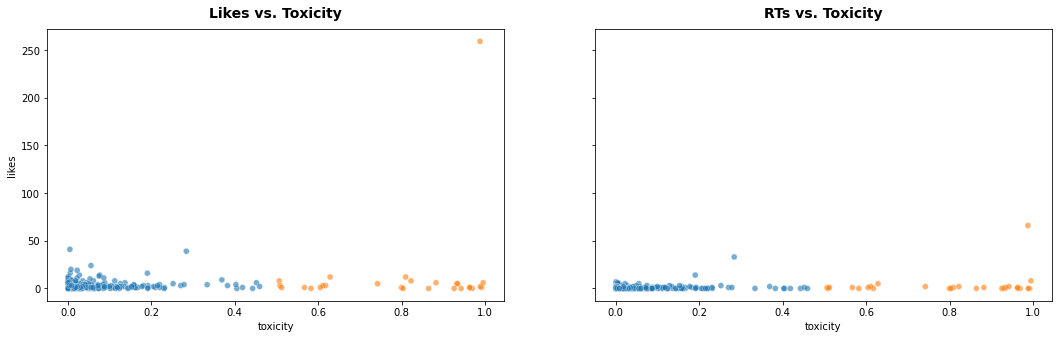

In [79]:
# Toxicity vs. Likes & RTs
# ------------------------------------------------------------------------------
# Figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharex=True, sharey=True)

# Titles
ax1.set_title("Likes vs. Toxicity", y=1.02, fontsize=14, fontweight='bold')
ax2.set_title("RTs vs. Toxicity", y=1.02, fontsize=14, fontweight='bold')

# Axes content
sns.scatterplot(ax=ax1, data=df, x='toxicity', y='likes', hue='class', alpha=0.6, legend=False)
sns.scatterplot(ax=ax2, data=df, x='toxicity', y='RTs', hue='class', alpha=0.6, legend=False);

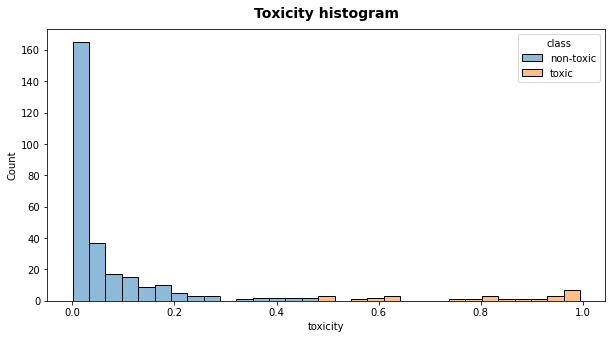

In [60]:
# Toxicity histogram
# ------------------------------------------------------------------------------
# Figure and axes
fig, ax = plt.subplots(figsize=(10,5))

# Titles
ax.set_title("Toxicity histogram", y=1.02, fontsize=14, fontweight='bold')

# Toxicity evolution through time
sns.histplot(ax=ax, data=df, x='toxicity', hue='class', legend=True, fill=True);

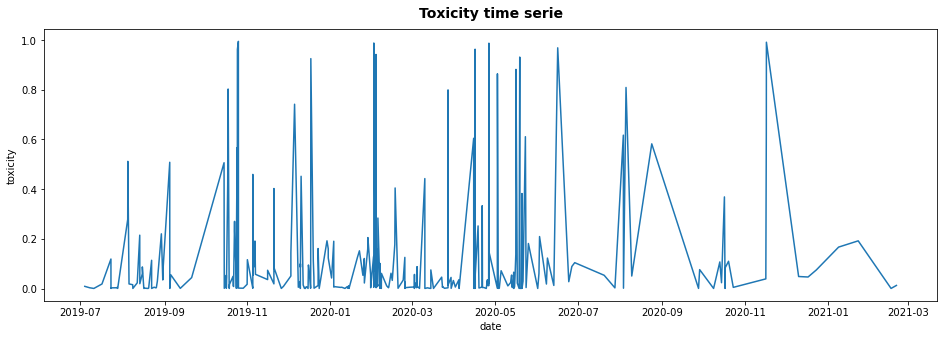

In [53]:
# Evolution of toxicity thorugh time
# ------------------------------------------------------------------------------
# Figure and axes
fig, ax = plt.subplots(1, figsize=(16,5))

# Titles
ax.set_title("Toxicity time serie", y=1.02, fontsize=14, fontweight='bold')

# Toxicity evolution through time
sns.lineplot(ax=ax, data=df, x="date", y="toxicity");

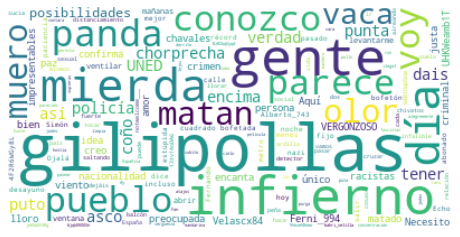

In [67]:
# Word Cloud
# ------------------------------------------------------------------------------
# Combine all tweets
text = " ".join(review for review in df['tweet'])

# Define a list of stopword to eliminate from the word cloud
stop_words = stopwords.words('spanish')
stop_words += ["t", "si", "https", "co"]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## X. Bibliografía

- http://docs.tweepy.org/en/latest/
- https://github.com/unitaryai/detoxify

## X. Info a revisar

- Limpieza de datos con regex: http://rios.tecnm.mx/cdistribuido/recursos/MinDatScr/MineriaScribble.html
- Web objetivo: https://www.ninjalitics.com/


- Traduction --> TextBlob
- Sentiment Analysis --> TextBlob
- Universal Dependencies --> GSD

Preparar un traductor con TextBlob:

TextBlob también tiene análisis de opinión:

Mapa de palabras
Qué temas son los más candentes para este señor?
Cuándo publica más odio?

https://antonio-fernandez-troyano.medium.com/nube-de-palabras-word-cloud-con-python-a-partir-de-varias-webs-111e94220822
https://www.datacamp.com/community/tutorials/wordcloud-python

In [ ]:
Libreria de traduccion
lexicon de palabras
graficos nuevos --> tendencia de mensajes d eodio en el tiempo, mapa de palabras
streamlit

In [ ]:
https://blog.usejournal.com/why-and-how-to-make-a-requirements-txt-f329c685181e